# NextValue

## Bibliotecas Necessárias

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt

## Processamento dos Dados

### Importando o Dataset

A primeira coisa a se fazer é pegar os nomes dos arquivos que contém os valores das criptomoedas.

Para adicionar uma nova criptomoeda, basta colocar o arquivo com os valores na pasta <b>Prices</b> e o código abaixo irá adicioná-lo na lista de arquivos.

In [2]:
DATA_PATH = "./Prices"

dataset_list = [f for f in listdir(DATA_PATH) if (isfile(join(DATA_PATH, f)) and f.endswith(".csv"))]
dataset_list.sort()

### Dados Necessários

<b>NUMBER_OF_CRYPTOCURRENCIES</b> é o número de criptomoedas diferentes que serão usadas. Esse valor será necessário algumas no código.

<b>CRYPTOCURRENCY_INDEX</b> é usado no final do notebook para facilitar a visualização dos resultados pelo usuário (basta trocar o nome da criptomoeda que se deseja ver e o código cuidará do resto).

In [3]:
NUMBER_OF_CRYPTOCURRENCIES = len(dataset_list)

cryptocurrency_list = [d[:-4] for d in dataset_list]
index = [i for i in range(NUMBER_OF_CRYPTOCURRENCIES)]

CRYPTOCURRENCY_INDEX = dict(zip(cryptocurrency_list, index))

### Juntando os datasets

O código abaixo tem a função de pegar todos os arquivos e juntar as informações em uma única estrutura de dados chamada <b>dataset</b>. Cada linha é o valor da criptomoeda em um dia específico. Cada coluna é uma criptomoeda diferente.

<b>dataset[d, c]</b> = <b>valor</b> da criptomoeda <b>c</b> no dia <b>d</b>.

Algumas criptomoedas não existiam antes de determinada data, enquanto outras já existiam. Nesses casos, o valor da criptomoeda antes da sua criação é <b>US$ 0,00</b>.

In [4]:
dataset = pd.read_csv(DATA_PATH + "/Bitcoin.csv")
dataset = dataset.iloc[:, 1:3]

for i in range(0, NUMBER_OF_CRYPTOCURRENCIES):
    file = pd.read_csv(DATA_PATH + "/" + dataset_list[i])
    file = file.iloc[:, 1:3]
    dataset = pd.merge(dataset, file, on='Date', how='outer')

dataset = dataset.iloc[:, 2:NUMBER_OF_CRYPTOCURRENCIES+2]
dataset = dataset.replace(np.nan, 0)

### Dividindo o Dataset em TrainingSet e TestSet

<b>NUMBER_OF_ROWS</b> é a quantidade de dias (ou seja, a quantidade de linhas) no dataset.

<b>TRAINING_RATE</b> é o quanto do dataset será usado para treinar. Exemplo: Se o valor for 0.95, significa que 95% do dataset é para treino e 5% é para teste.

<b>TRAINING_SET_SIZE</b> é a qunatidade de dias no conjunto de treino.

<b>TEST_SET_SIZE</b> é a qunatidade de dias no conjunto de teste.


In [5]:
NUMBER_OF_ROWS = dataset.shape[0]
TRAINING_RATE = 0.95
TRAINING_SET_SIZE = math.ceil(NUMBER_OF_ROWS*TRAINING_RATE)
TEST_SET_SIZE = NUMBER_OF_ROWS - TRAINING_SET_SIZE

training_set = dataset.iloc[:TRAINING_SET_SIZE, : ].values
test_set = dataset.iloc[TRAINING_SET_SIZE:, : ].values

### Feature Scaling

Os valores 0 e 1 no feature_range servem para manter os valores transformados entre esses números.

In [6]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Construindo a Estrutura de Dados

<b>DIAS_ANTERIORES</b> é a quantidade de dias que entram no cálculo para prever o valor do dia seguinte.

In [7]:
PREVIOUS_DAYS = 5

X_train = []
y_train = []
for i in range(PREVIOUS_DAYS, TRAINING_SET_SIZE):
    X_train.append(training_set_scaled[i-PREVIOUS_DAYS:i, 0:NUMBER_OF_CRYPTOCURRENCIES])
    y_train.append(training_set_scaled[i, 0:NUMBER_OF_CRYPTOCURRENCIES])

X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

Muda a "forma" do dataset de treinamento, adicionando uma nova dimensão. A rede neural que será construída espera uma entrada com a forma abaixo.

A forma 3D resultante é a seguinte:

(Total de Dias, Dias Anteriores, Numero de Criptomoedas)

In [8]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], NUMBER_OF_CRYPTOCURRENCIES))

## Construindo a Rede Neural

A rede neural será construída e treinada nas próximas etapas.

As configurações atuais foram escolhidas com base em outras tentativas com outras configurações.

### Inicializando a Rede

<b>UNITS</b> é a quantidade de neurônios

In [9]:
UNITS = 300

regressor = Sequential()

### Adicionando a camada LSTM e Dropout

A quantidade de neurônios e o dropout foram escolhidos após diversas tentativas com outros valores.

In [10]:
regressor.add(LSTM(units = UNITS, input_shape = (X_train.shape[1], NUMBER_OF_CRYPTOCURRENCIES)))
regressor.add(Dropout(0.2))

### Adicionando a camada de saída

Já que haverá uma saída para cada criptomoeda, o número de saídas deve ser o mesmo de criptomoedas.

In [11]:
regressor.add(Dense(units = NUMBER_OF_CRYPTOCURRENCIES))

### Compilando a Rede

O otimizador e o loss foram escolhidos após diversas tentativas com outros valores.

In [12]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Treinando a Rede Neural

Os epochs e o batch_size foram escolhidos após diversas tentativas com outros valores.

In [13]:
regressor.fit(X_train, y_train, epochs = 300, batch_size = 96)

0
28/28 [==============================] - 0s 17ms/step - loss: 7.5315e-04
Epoch 71/300
28/28 [==============================] - 0s 15ms/step - loss: 3.6470e-04
Epoch 72/300
28/28 [==============================] - 0s 16ms/step - loss: 5.1659e-04
Epoch 73/300
28/28 [==============================] - 0s 15ms/step - loss: 6.8967e-04
Epoch 74/300
28/28 [==============================] - 0s 15ms/step - loss: 6.6284e-04
Epoch 75/300
28/28 [==============================] - 0s 16ms/step - loss: 5.9869e-04
Epoch 76/300
28/28 [==============================] - 0s 16ms/step - loss: 3.9379e-04
Epoch 77/300
28/28 [==============================] - 0s 15ms/step - loss: 4.0686e-04
Epoch 78/300
28/28 [==============================] - 1s 19ms/step - loss: 6.6101e-04
Epoch 79/300
28/28 [==============================] - 0s 15ms/step - loss: 4.2428e-04
Epoch 80/300
28/28 [==============================] - 0s 17ms/step - loss: 6.6495e-04
Epoch 81/300
28/28 [==============================] - 0s 15ms/ste

## Testando a Rede Neural

Prepara o dataset de teste para que a rede faça a previsão dos preços das criptomoedas.

In [14]:
inputs = dataset[TRAINING_SET_SIZE-PREVIOUS_DAYS:].values
inputs = inputs.reshape((inputs.shape[0], inputs.shape[1]))
inputs = sc.transform(inputs)

X_test = []
for i in range(PREVIOUS_DAYS, PREVIOUS_DAYS+TEST_SET_SIZE):
  X_test.append(inputs[i-PREVIOUS_DAYS:i, 0:NUMBER_OF_CRYPTOCURRENCIES])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], NUMBER_OF_CRYPTOCURRENCIES))

predict = regressor.predict(X_test)
predict = sc.inverse_transform(predict)

## Visualizando os Resultados

Mostra um gráfico comparando os valores previstos pela rede neural e o valor verdadeiro.

Para trocar a criptomoeda, basta trocar o nome dela abaixo.

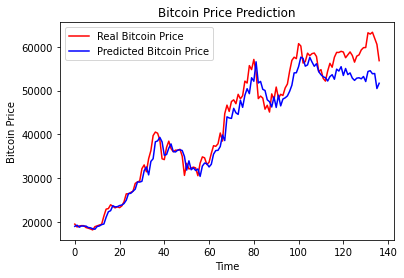

In [15]:
CRYPTOCURRENCY = "Bitcoin"

INDEX_OF_CRYPTOCURRENCY = CRYPTOCURRENCY_INDEX[CRYPTOCURRENCY]

test_cryptocurrency = []
predict_cryptocurrency = []

for i in range(TEST_SET_SIZE):
  test_cryptocurrency.append(test_set[i, INDEX_OF_CRYPTOCURRENCY])
  predict_cryptocurrency.append(predict[i, INDEX_OF_CRYPTOCURRENCY])

plt.plot(test_cryptocurrency, color = 'red', label = 'Real ' + CRYPTOCURRENCY + ' Price')
plt.plot(predict_cryptocurrency, color = 'blue', label = 'Predicted ' + CRYPTOCURRENCY + ' Price')
plt.title(CRYPTOCURRENCY + ' Price Prediction')
plt.xlabel('Time')
plt.ylabel(CRYPTOCURRENCY + ' Price')
plt.legend()
plt.show()